#  Название проекта: Аналитический кейс стартапа, который продаёт продукты питания

**Описание исследования.**

Нужно разобраться, как ведут себя пользователи мобильного приложения. Исследовать результаты A/A/B-эксперимента.

**Цель исследования.**

- Изучить воронку продаж. Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. На каких именно шагах.

- Выяснить, какой шрифт лучше: дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми.

**Задачи исследования.**

- выгрузить датасеты и изучить по ними общую информацию;
- подготовьте данные: проверить названия столбцов, проверьть пропуски и типы данных;
- изучить данные;
- изучить воронку событий;
- изучить результаты эксперимента;
- сделать выводы и рекомендации.

**Исходные данные.**

В нашем распоряжении датасет:
 - **logs_exp.csv** - каждая запись в логе — это действие пользователя, или событие
 
Структура **logs_exp.csv:**

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная



**Данное исследование разделим на несколько частей.**

***Часть 1. Изучение общей информации и подготовка данных:***

* [1. Изучение файлов с данными, получение общей информации, загрузка библиотек](#1.1-bullet)
* [2. Замена названий столбцов](#1.2-bullet)
* [3. Обработка дубликатов](#1.3-bullet)
* [4. Обработка типов данных](#1.3-bullet)
* [5. Проверка данных](#1.4-bullet)

***Часть 2. Воронка событий:***

* [1. События в логах](#2.1-bullet)
* [2. Распределение событий по числу пользователей](#2.2-bullet)
* [3. Визуализация воронки событий](#2.3-bullet)
* [4. Конверсия событий среди пользователей](#2.4-bullet)

***Часть 3. Результаты эксперимента:***

* [1. Функция для проверки статистически достоверных отличий между группами](#3.1-bullet)
* [2. Уровень статистической значимости alpha](#3.2-bullet)
* [3. Статистические отличия между выборками контрольной - 246 и контрольной - 247](#3.3-bullet)
* [4. Статистические отличия между выборками контрольной - 246 и экспериментальной - 248](#3.4-bullet)
* [5. Статистические отличия между выборками контрольной - 247 и экспериментальной - 248](#3.5-bullet)
* [6. Статистические отличия между объединённой контрольной группой - 246+247 и экспериментальной - 248](#3.6-bullet)

[***ВЫВОД***](#4-bullet)

## Загрузка данных и подготовка их к анализу

In [1]:
# импортировали библиотеки Pyhton для проведения исследования
import pandas as pd 
from matplotlib import pyplot as plt
import numpy as np
import math as mth
import datetime as dt
import plotly.express as px
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

<a id='1.1-bullet'></a>
### Считывание CSV-файлов с данными с помощью библиотеки pandas

In [2]:
# считали файл из csv-файла в переменную
try:
    logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
except:
    logs = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
# создали функцию для просмотра и вывода информации датафрейма
def info(df):
    display(df.head(10))
    print(df.info(), '*'*50, sep='\n')
    print(df.duplicated().sum(), '*'*50, sep='\n');

In [4]:
info(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None
**************************************************
413
**************************************************


В датафрейме 244126 строк и 5 столбцов, нет пропусков, найдены дубликаты. Столбец с датой EventTimestamp представлен как временная метка в формате Timestamp. Для дальнейшего исследования необходимо будет преобразовать столбец в привычную дату и время.

<a id='1.2-bullet'></a>
### Замена названий столбцов

Заменим названия столбцов: приведем к змеиному регистру

In [5]:
#изменили названия столбцов
logs.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']

In [6]:
logs.columns  #вывели исправленные названия

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

<a id='1.3-bullet'></a>
### Обработка дубликатов

In [7]:
# проверили на дубликаты
logs.duplicated().sum()

413

In [8]:
'Доля дубликатов в датафрейме - {:.2%}'.format(logs.duplicated().sum() / logs.shape[0])

'Доля дубликатов в датафрейме - 0.17%'

Найдено 413 дубликатов, 0.17% от всех строк в датафрейме.

In [9]:
# удалили дубликаты
logs.drop_duplicates(inplace=True)

In [10]:
# проверили еще раз на дубликаты по столбцам
logs.duplicated(subset=['event_name', 'device_id_hash', 'event_timestamp']).sum()

0

In [11]:
# проверили удаление дубликатов
logs.duplicated().sum()

0

<a id='1.4-bullet'></a>
### Обработка типов данных

Столбец с датой EventTimestamp представлен как временная метка в формате Timestamp. Добавим столбцев с датой и временем, и отдельный столбец с датой

In [12]:
# добавили столбец с датой и временем события
logs['event_datetime'] = pd.to_datetime(logs['event_timestamp'], unit='s')

In [13]:
# добавили столбец с датой
logs['event_date'] = pd.to_datetime(logs['event_datetime'].apply(lambda x: x.date()), format='%Y-%m-%d')

In [14]:
logs.head() # вывели датафрейм в добавленными столбцами

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [15]:
# проверили типы данных в добавленных столбцах
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_datetime   243713 non-null  datetime64[ns]
 5   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


<a id='1.5-bullet'></a>
### Проверка данных

In [16]:
# посчитали сколько строк было изначально в датафрейме
before = logs.shape[0]
before

243713

In [17]:
# проверили, сколько событий в логе
logs['event_name'].nunique()

5

In [18]:
# вывели назавания событий
logs['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

В датафрейме всего 5 событий: MainScreenAppea - главный экран, PaymentScreenSuccessful - успешная оплата, CartScreenAppear - корзина, OffersScreenAppear - предложения, Tutorial - описание.

In [19]:
# проверили сколько всего пользователей в логе
before_users = logs['device_id_hash'].nunique()
before_users

7551

В датафрейме 7551 уникальный пользователь на начало исследования.

In [20]:
# проверили сколько в среднем событий приходиться на 1 пользователя
np.round(
    logs.groupby('device_id_hash', as_index=False)
    .agg({'event_name': 'count'})['event_name']
    .mean()
)

32.0

На одного пользователя приходится в среднем 32 события.

In [21]:
# вывели сводную таблицу количества событий на пользователя
logs_event = logs.groupby(
    'device_id_hash', as_index=False
).agg(
    {'event_name': 'count'}
).sort_values('event_name', ascending=False)
logs_event

,device_id_hash,event_name
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
...,...,...
6013,7399061063341528729,1
2356,2968164493349205501,1
6575,8071397669512236988,1
311,425817683219936619,1


In [22]:
# вывели статистику по событиям на пользователя
logs_event['event_name'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

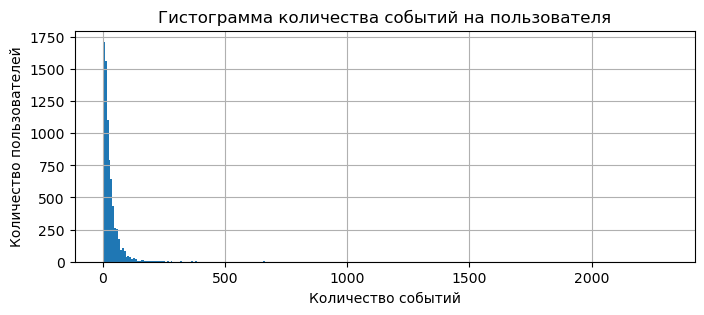

In [23]:
# гистограмма событий, совершенных пользователями
plt.figure(figsize=(8, 3))
logs_event['event_name'].hist(bins=300)
plt.xlabel('Количество событий')
plt.ylabel('Количество пользователей')
plt.title('Гистограмма количества событий на пользователя')
plt.show();

In [24]:
#посчитаем 95-й и 99-й перцентили количества событий на пользователя
print(np.percentile(logs_event['event_name'], [95, 99]))

[ 89.  200.5]


In [25]:
# вывели пользователей у которых количество событий превышает 99-й перцентиль
logs_event[logs_event['event_name'] > 200.5]

,device_id_hash,event_name
5116,6304868067479728361,2307
147,197027893265565660,1998
3714,4623191541214045580,1768
5590,6932517045703054087,1439
1391,1754140665440434215,1221
...,...,...
1216,1553654098241439838,208
216,284324717439504162,208
4190,5178884875886952056,207
1934,2457989834692826118,203


In [26]:
#удалили аномальных пользователей
logs = logs[~logs['device_id_hash'].isin(logs_event[logs_event['event_name'] > 200.5]['device_id_hash'])]

Как было отмечено ранее на пользователя приходится в среднем 32 события, медиана количества событий на пользователя составляет 20 событий. Максимальное количество событий, которое совершил пользователь составляет 2307. У 76 пользователей можно обнаружить аномально большое количество событий более 200 - 99 перцентиль количества событий на пользователя.

In [27]:
# найшли максимальную и минимальную дату.
print(logs['event_date'].min().date())
print(logs['event_date'].max().date())

2019-07-25
2019-08-07


В датафрейме данные с 25 июля 2019 года по 07 августа 2019 года

Изучим, как меняется количество данных: построим столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. 

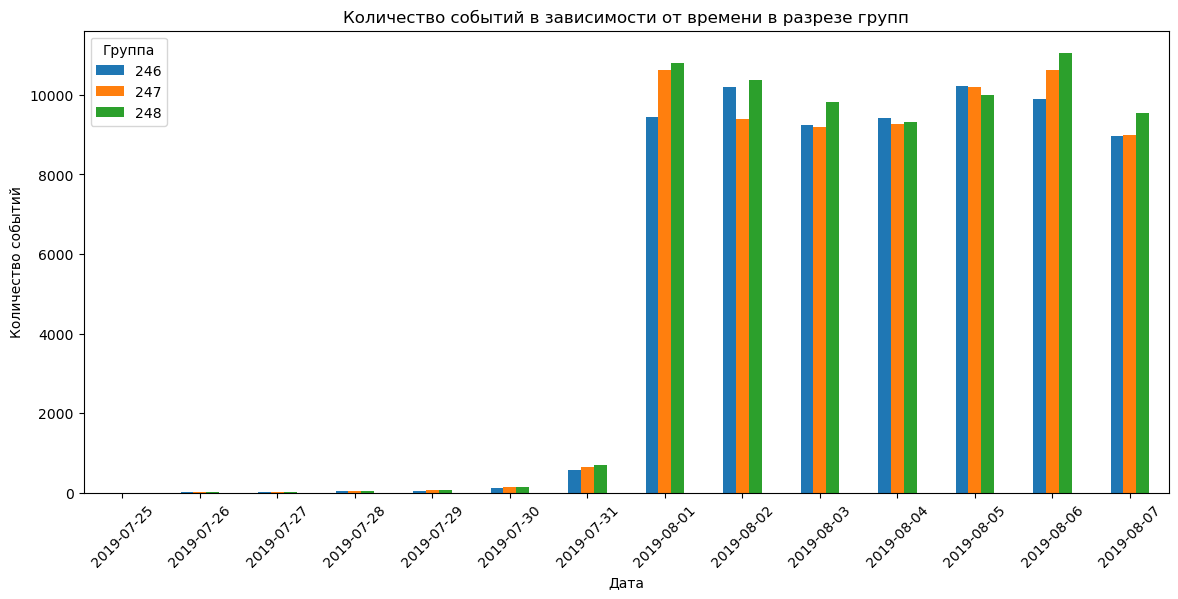

In [28]:
# построили столбчатую диаграмму
pd.pivot_table(
    logs, 
    index = logs['event_date'].dt.date,
    columns='exp_id',
    values='event_name',
    aggfunc='count').plot.bar(figsize=(14, 6))

plt.legend(loc='upper left', title='Группа')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)
plt.show()

Исходя из графика одинаково полные данные есть за период с 01.08.2019 по 07.08.2019.

In [29]:
# удалили данные до 01.08.2019
logs = logs[logs['event_date'] >= '2019-08-01']
logs.sort_values('event_date')

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
26351,MainScreenAppear,5807560156115311891,1564673017,246,2019-08-01 15:23:37,2019-08-01
26350,OffersScreenAppear,342904511578898557,1564673016,247,2019-08-01 15:23:36,2019-08-01
26349,MainScreenAppear,1458354809465956900,1564673015,247,2019-08-01 15:23:35,2019-08-01
26347,MainScreenAppear,7416695313311560658,1564673012,246,2019-08-01 15:23:32,2019-08-01
...,...,...,...,...,...,...
223054,MainScreenAppear,2088762857561440959,1565172081,247,2019-08-07 10:01:21,2019-08-07
223053,CartScreenAppear,3980825915805890698,1565172080,246,2019-08-07 10:01:20,2019-08-07
223052,MainScreenAppear,1887002214999686051,1565172067,248,2019-08-07 10:01:07,2019-08-07
223050,MainScreenAppear,3909945206876963575,1565172058,247,2019-08-07 10:00:58,2019-08-07


In [30]:
# проверили, что пользователи принадлежат только какой-то одной группе и не пересекаются
users = logs.groupby('device_id_hash', as_index=False).agg({'exp_id': 'nunique'})
users[(users['exp_id'] > 1) | (users['exp_id'] < 1)] #вывели пересечения

,device_id_hash,exp_id


In [31]:
# проверили, что есть пользователи из всех трёх экспериментальных групп
groups = logs.pivot_table(
    index = 'exp_id',
    values = 'device_id_hash',
    aggfunc = 'nunique',
    margins=True
).reset_index()
groups.columns = ['group', 'users_count']
groups

,group,users_count
0,246,2456
1,247,2491
2,248,2511
3,All,7458


In [32]:
after = logs.shape[0]
after

206615

In [33]:
after_users = logs['device_id_hash'].nunique()
after_users

7458

In [34]:
print('Потеряли значений после обработки аномалий - {:.1%}'.format((before-after)/before))
print('Потеряли пользователей после обработки аномалий - {:.1%}'.format((before_users-after_users)/before_users))

Потеряли значений после обработки аномалий - 15.2%
Потеряли пользователей после обработки аномалий - 1.2%


В данном разделе зарузили датафрейм, посмотрели на данные, удалили дубликаты, привели столбцы к змеиному регистру. Данные были предоставлены за период с 25 июля 2019 года по 07 августа 2019 года. После проверки выяснили, что полные данные представлены только с 1 августа 2019 года. Проверили, что пользователи принадлежат какой-то одной группе и не пересекаются. Удалили аномальных пользователей, которые совершили очень много событий.

## Воронка событий

In [35]:
pd.set_option('display.float_format', '{:.2%}'.format) #опция для отображения доли в процентах

<a id='2.1-bullet'></a>
### События в логах

Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте.

In [36]:
# посмотрели на события в логах
logs['event_name'].value_counts()

event_name
MainScreenAppear           113264
OffersScreenAppear          40956
CartScreenAppear            29250
PaymentScreenSuccessful     22164
Tutorial                      981
Name: count, dtype: int64

В датафрейме всего 5 событий: MainScreenAppea - главный экран, OffersScreenAppear - предложения, CartScreenAppear - корзина, PaymentScreenSuccessful - успешная оплата, Tutorial - описание.

<a id='2.2-bullet'></a>
### Распределение событий по числу пользователей

Посчитаем, сколько пользователей совершали каждое из событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие от общего количества уникальных пользователей

In [37]:
# посчитали, сколько пользователей совершали каждое из этих событий. 
users = logs.groupby(
    'event_name', as_index=False
).agg({'device_id_hash': 'nunique'}).sort_values('device_id_hash', ascending=False).reset_index(drop=True)
users.columns = ['event', 'users_count']
users

,event,users_count
0,MainScreenAppear,7344
1,OffersScreenAppear,4517
2,CartScreenAppear,3658
3,PaymentScreenSuccessful,3463
4,Tutorial,824


In [38]:
# доля пользователей, которые хоть раз совершали определенное событие
users['user_share'] = (users['users_count'] / logs['device_id_hash'].nunique())
users

,event,users_count,user_share
0,MainScreenAppear,7344,98.47%
1,OffersScreenAppear,4517,60.57%
2,CartScreenAppear,3658,49.05%
3,PaymentScreenSuccessful,3463,46.43%
4,Tutorial,824,11.05%


События происходят в следующем порядке MainScreenAppear - OffersScreenAppear - CartScreenAppear - PaymentScreenSuccessful.
События Tutorial не входит в общую воронку, т.к. не все пользователи читают описание и это вспомогательный интрумент продажи.

In [39]:
# удалим данное событие
users = users[0:4]
users

,event,users_count,user_share
0,MainScreenAppear,7344,98.47%
1,OffersScreenAppear,4517,60.57%
2,CartScreenAppear,3658,49.05%
3,PaymentScreenSuccessful,3463,46.43%


<a id='2.3-bullet'></a>
### Визуализация воронки событий

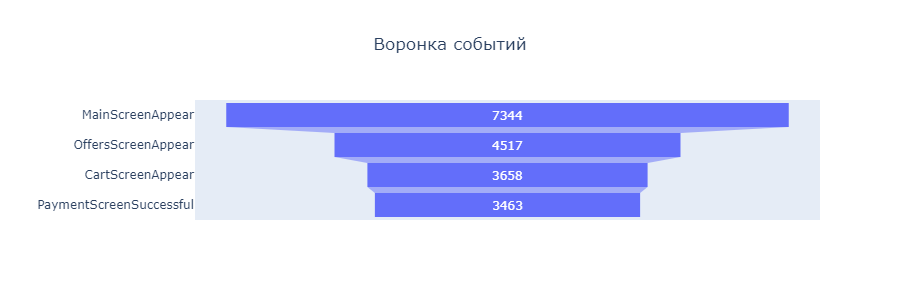

In [40]:
#визуализируем воронку
fig = px.funnel(users, 
                x=list(users['users_count']), 
                y=list(users['event']), 
                title='Воронка событий',
                width=900, 
                height=300,
               )
fig.update_layout(title_text='Воронка событий', 
                  title_x=0.5,
                  yaxis_title='')
fig.show('png')

<a id='2.4-bullet'></a>
### Конверсия событий среди пользователей

По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем).

In [41]:
#посчитали долю пользователей, которые переходят на следующее событие по воронке
users['conversion'] = users['users_count'] / users['users_count'].shift()
users

,event,users_count,user_share,conversion
0,MainScreenAppear,7344,98.47%,NaN
1,OffersScreenAppear,4517,60.57%,61.51%
2,CartScreenAppear,3658,49.05%,80.98%
3,PaymentScreenSuccessful,3463,46.43%,94.67%


Больше всего пользоватлей теряется при переходе с этапа MainScreenAppear на OffersScreenAppear - порядка 38%.

In [42]:
# посчитаем какая доля пользователей доходит от первого события до оплаты

print(
    'Дошли до оплаты - {:.2%} пользователей'
    .format(users['users_count'][users[users['event'] == 'PaymentScreenSuccessful'].index[0]] / 
    users['users_count'][users[users['event'] == 'MainScreenAppear'].index[0]])
)

Дошли до оплаты - 47.15% пользователей


На данном этапе посмотрели на события, которые есть в логах и распределили их по пользователям в воронку, посмотрели на конверсию пользователей, сколько из них переходят на следующих этап по сравнению с предыдущим. Нашли долю пользователей, которые доходят с первого этапа на последний. Визуализировали воронку для наглядности.

## Результаты эксперимента

<a id='3.1-bullet'></a>
### Функция для проверки статистически достоверных отличий между группами

Создадим функцию, которая будет считать число пользователей, совершивших событие в каждой из контрольных групп. Считать долю пользователей, совершивших событие. Проверять, будет ли отличие между группами статистически достоверным. 

In [43]:
#Количество пользователей в каждой контрольной группе находили на прошлых этапах
groups

,group,users_count
0,246,2456
1,247,2491
2,248,2511
3,All,7458


In [44]:
# вывели сводную таблицу по количеству пользователей по группам и событиям
groups_test = logs.pivot_table(
    index='event_name', columns='exp_id', values='device_id_hash', aggfunc='nunique'
).sort_values(246, ascending=False).reset_index()
groups_test

exp_id,event_name,246,247,248
0,MainScreenAppear,2423,2454,2467
1,OffersScreenAppear,1514,1498,1505
2,CartScreenAppear,1238,1216,1204
3,PaymentScreenSuccessful,1172,1136,1155
4,Tutorial,269,279,276


In [45]:
# объединили пользователей из контрольных групп в одну
groups_merge = logs[(logs['exp_id'] == 246)|(logs['exp_id'] == 247)].pivot_table(
    index='event_name', values='device_id_hash', aggfunc='nunique'
).sort_values('device_id_hash', ascending=False).reset_index()
groups_merge.columns = ['event_name', '246+247']
groups_merge

,event_name,246+247
0,MainScreenAppear,4877
1,OffersScreenAppear,3012
2,CartScreenAppear,2454
3,PaymentScreenSuccessful,2308
4,Tutorial,548


In [46]:
# oбъеденили все в одну таблицу
groups_test = groups_test.merge(groups_merge, left_on = 'event_name', right_on = 'event_name', how='left')
groups_test

,event_name,246,247,248,246+247
0,MainScreenAppear,2423,2454,2467,4877
1,OffersScreenAppear,1514,1498,1505,3012
2,CartScreenAppear,1238,1216,1204,2454
3,PaymentScreenSuccessful,1172,1136,1155,2308
4,Tutorial,269,279,276,548


In [47]:
# добавили общее количество пользователей в группах

groups_test = pd.DataFrame(
    np.insert(groups_test.values, 
              0, 
              values=[
                  'AllUsers', 
                   logs[logs['exp_id'] == 246]['device_id_hash'].nunique(), 
                   logs[logs['exp_id'] == 247]['device_id_hash'].nunique(), 
                   logs[logs['exp_id'] == 248]['device_id_hash'].nunique(), 
                   logs[(logs['exp_id'] == 246)|(logs['exp_id'] == 247)]['device_id_hash'].nunique()], axis= 0)
)
groups_test.columns = ['event', 246, 247, 248, '246+247']
groups_test

,event,246,247,248,246+247
0,AllUsers,2456,2491,2511,4947
1,MainScreenAppear,2423,2454,2467,4877
2,OffersScreenAppear,1514,1498,1505,3012
3,CartScreenAppear,1238,1216,1204,2454
4,PaymentScreenSuccessful,1172,1136,1155,2308
5,Tutorial,269,279,276,548


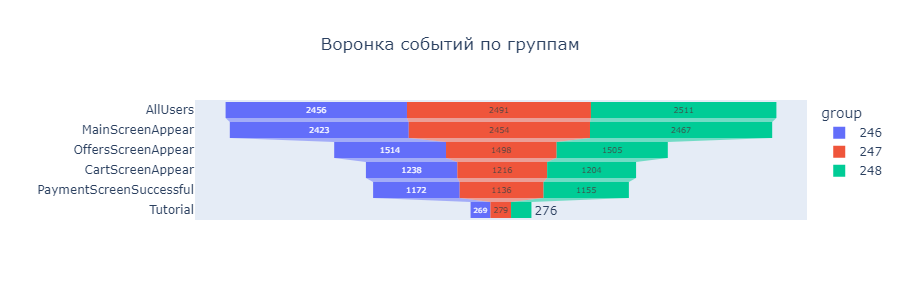

In [48]:
#визуализировали воронку событий по группам

stages = list(groups_test['event'])

df_246 = pd.DataFrame(dict(number=list(groups_test[246]), stage=stages))
df_246['group'] = '246'

df_247 = pd.DataFrame(dict(number=list(groups_test[247]), stage=stages))
df_247['group'] = '247'

df_248 = pd.DataFrame(dict(number=list(groups_test[248]), stage=stages))
df_248['group'] = '248'

df = pd.concat([df_246, df_247, df_248], axis=0)

fig = px.funnel(df, x='number', 
                y='stage', 
                color='group', 
                title='Воронка событий по группам',
                width=900, 
                height=300
               )
fig.update_layout(title_text='Воронка событий по группам', 
                  title_x=0.5,
                  yaxis_title='')
fig.show('png')


In [49]:
# добавили доли пользователей, которые совершили каждое из событий в каждой группе
groups_test['246_user_part'] = (groups_test[246] / groups_test[246].values[0])
groups_test['247_user_part'] = (groups_test[247] / groups_test[247].values[0])
groups_test['248_user_part'] = (groups_test[248] / groups_test[248].values[0])
groups_test['246+247_user_part'] = (groups_test['246+247'] / groups_test['246+247'].values[0])
groups_test

,event,246,247,248,246+247,246_user_part,247_user_part,248_user_part,246+247_user_part
0,AllUsers,2456,2491,2511,4947,100.00%,100.00%,100.00%,100.00%
1,MainScreenAppear,2423,2454,2467,4877,98.66%,98.51%,98.25%,98.59%
2,OffersScreenAppear,1514,1498,1505,3012,61.64%,60.14%,59.94%,60.89%
3,CartScreenAppear,1238,1216,1204,2454,50.41%,48.82%,47.95%,49.61%
4,PaymentScreenSuccessful,1172,1136,1155,2308,47.72%,45.60%,46.00%,46.65%
5,Tutorial,269,279,276,548,10.95%,11.20%,10.99%,11.08%


Самое популярное событие открытие главного экран 'MainScreenAppear'- это сделали более 98% пользователей в каждой из групп

In [50]:
# напишем функцию, которая будет считать доли пользователей совершивших событие
# и проверять будет ли отличие между группами статистически достоверным

def ztest(event, group_1, group_2, alpha):
    alpha = alpha
    
    a1 = groups_test[group_1][groups_test[groups_test['event'] == event].index[0]]
    a2 = groups_test[group_2][groups_test[groups_test['event'] == event].index[0]]
    b1 = groups_test[group_1].values[0]
    b2 = groups_test[group_2].values[0]
    
    p1 = a1 / b1
    p2 = a2 / b2
    
    p_combined = (a1 + a2) / (b1 + b2)
    
    difference = p1 - p2
   
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/b1 + 1/b2))
    
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие -', event)
    print('Количество пользователей, совершивших событие:')
    print('группа -', group_1, '/', a1, '- пользователей', '/', 
          np.round(p1*100,2), '% - доля пользователей от общего количества в группе')
    print('группа -', group_2, '/', a2, '- пользователей', '/', 
          np.round(p2*100,2), '% - доля пользователей от общего количества в группе')
    print()
    print('Нулевая гипотеза - доли одинаковые')
    print('Альтернативная гипотеза - доли разные')
    print()
    print('Уровень значимости alpha: ', alpha)
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

<a id='3.2-bullet'></a>
### Уровень статистической значимости alpha

Зададим уровень статистической значимости alpha - уровне значимости, при котором можно ошибочно отклонить нулевую гипотезу при условии, что она верна.

In [51]:
# задали 0.05 (в 5% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна)
alpha = 0.05

<a id='3.3-bullet'></a>
### Статистические отличия между выборками контрольной - 246 и контрольной - 247

#### Событие - MainScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [52]:
ztest('MainScreenAppear', 246, 247, alpha)

Событие - MainScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 2423 - пользователей / 98.66 % - доля пользователей от общего количества в группе
группа - 247 / 2454 - пользователей / 98.51 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.6730951807208485
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - OffersScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [53]:
ztest('OffersScreenAppear', 246, 247, alpha)

Событие - OffersScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 1514 - пользователей / 61.64 % - доля пользователей от общего количества в группе
группа - 247 / 1498 - пользователей / 60.14 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.27702771700769824
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - CartScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [54]:
ztest('CartScreenAppear', 246, 247, alpha)

Событие - CartScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 1238 - пользователей / 50.41 % - доля пользователей от общего количества в группе
группа - 247 / 1216 - пользователей / 48.82 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.26299626637167783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - PaymentScreenSuccessful

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [55]:
ztest('PaymentScreenSuccessful', 246, 247, alpha)

Событие - PaymentScreenSuccessful
Количество пользователей, совершивших событие:
группа - 246 / 1172 - пользователей / 47.72 % - доля пользователей от общего количества в группе
группа - 247 / 1136 - пользователей / 45.6 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.13586258367273985
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

<a id='3.4-bullet'></a>
### Статистические отличия между выборками контрольной - 246 и экспериментальной - 248

#### Событие - MainScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [56]:
ztest('MainScreenAppear', 246, 248, alpha)

Событие - MainScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 2423 - пользователей / 98.66 % - доля пользователей от общего количества в группе
группа - 248 / 2467 - пользователей / 98.25 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.24380010740478975
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - OffersScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [57]:
ztest('OffersScreenAppear', 246, 248, alpha)

Событие - OffersScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 1514 - пользователей / 61.64 % - доля пользователей от общего количества в группе
группа - 248 / 1505 - пользователей / 59.94 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.21751867407994285
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - CartScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [58]:
ztest('CartScreenAppear', 246, 248, alpha)

Событие - CartScreenAppear
Количество пользователей, совершивших событие:
группа - 246 / 1238 - пользователей / 50.41 % - доля пользователей от общего количества в группе
группа - 248 / 1204 - пользователей / 47.95 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.08317408116828573
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста и уровне alpha - 0.05 не получилось найти статистически достоверных отличий в этом событии. При alpha - 0.1 между долями есть значимая разница.

#### Событие - PaymentScreenSuccessful

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [59]:
ztest('PaymentScreenSuccessful', 246, 248, alpha)

Событие - PaymentScreenSuccessful
Количество пользователей, совершивших событие:
группа - 246 / 1172 - пользователей / 47.72 % - доля пользователей от общего количества в группе
группа - 248 / 1155 - пользователей / 46.0 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.2239322340682175
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

<a id='3.5-bullet'></a>
### Статистические отличия между выборками контрольной - 247 и экспериментальной - 248

#### Событие - MainScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [60]:
ztest('MainScreenAppear', 247, 248, alpha)

Событие - MainScreenAppear
Количество пользователей, совершивших событие:
группа - 247 / 2454 - пользователей / 98.51 % - доля пользователей от общего количества в группе
группа - 248 / 2467 - пользователей / 98.25 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.4545336230756303
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - OffersScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [61]:
ztest('OffersScreenAppear', 247, 248, alpha)

Событие - OffersScreenAppear
Количество пользователей, совершивших событие:
группа - 247 / 1498 - пользователей / 60.14 % - доля пользователей от общего количества в группе
группа - 248 / 1505 - пользователей / 59.94 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.8850746269495819
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - CartScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [62]:
ztest('CartScreenAppear', 247, 248, alpha)

Событие - CartScreenAppear
Количество пользователей, совершивших событие:
группа - 247 / 1216 - пользователей / 48.82 % - доля пользователей от общего количества в группе
группа - 248 / 1204 - пользователей / 47.95 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.539679592997024
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - PaymentScreenSuccessful

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [63]:
ztest('PaymentScreenSuccessful', 247, 248, alpha)

Событие - PaymentScreenSuccessful
Количество пользователей, совершивших событие:
группа - 247 / 1136 - пользователей / 45.6 % - доля пользователей от общего количества в группе
группа - 248 / 1155 - пользователей / 46.0 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.7800603242138475
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

<a id='3.6-bullet'></a>
### Статистические отличия между объединённой контрольной группой - 246+247 и экспериментальной - 248

#### Событие - MainScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [64]:
ztest('MainScreenAppear', '246+247', 248, alpha)

Событие - MainScreenAppear
Количество пользователей, совершивших событие:
группа - 246+247 / 4877 - пользователей / 98.59 % - доля пользователей от общего количества в группе
группа - 248 / 2467 - пользователей / 98.25 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.26186402859555846
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - OffersScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [65]:
ztest('OffersScreenAppear', '246+247', 248, alpha)

Событие - OffersScreenAppear
Количество пользователей, совершивших событие:
группа - 246+247 / 3012 - пользователей / 60.89 % - доля пользователей от общего количества в группе
группа - 248 / 1505 - пользователей / 59.94 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.42801834712141273
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - CartScreenAppear

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [66]:
ztest('CartScreenAppear', '246+247', 248, alpha)

Событие - CartScreenAppear
Количество пользователей, совершивших событие:
группа - 246+247 / 2454 - пользователей / 49.61 % - доля пользователей от общего количества в группе
группа - 248 / 1204 - пользователей / 47.95 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.17619153820927536
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

#### Событие - PaymentScreenSuccessful

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным.

In [67]:
ztest('PaymentScreenSuccessful', '246+247', 248, alpha)

Событие - PaymentScreenSuccessful
Количество пользователей, совершивших событие:
группа - 246+247 / 2308 - пользователей / 46.65 % - доля пользователей от общего количества в группе
группа - 248 / 1155 - пользователей / 46.0 % - доля пользователей от общего количества в группе

Нулевая гипотеза - доли одинаковые
Альтернативная гипотеза - доли разные

Уровень значимости alpha:  0.05
p-значение:  0.5908710902173984
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


По результатам z-теста не получилось найти статистически достоверных отличий в этом событии.

На данном этапе с помощью статистических критериев искали разницу между выборками. Разбиение на контрольные группы для А/А-эксперимента 246 и 247 произошло корректно - не было найдено статистически достоверных отличий в каждом из событий при заданном уровне статистичской значимости alpha - 0.05 (в 5% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна), при alpha - 0.1 (в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна) - также не было найдено статистически достоверных отличий.

Исследовав с помощью статистических критериев разницу между контрольными группами 246/247 и экспериментальной 248 (группой с изменённым шрифтом) при уровне статистичской значимости alpha - 0.05 не было найдено статистически достоверных отличий в событиях. В тоже время при alpha равным 0.1 в событии CartScreenAppear между контрольной группой 246 и экспериментальной 248 было найдено отличие в долях пользователей, совершивших это событие. 

По результатам A/A/B-теста можно сделать вывод, что измененные шрифты не влияют на пользователей и воронку продаж.

<a id='4-bullet'></a>
## ВЫВОД

При проведении исследования были получены данные о событиях стартапа, который продаёт продукты питания. 

В полученном датафрейме провели предобработку данных: заменили названия столбцов, преобразовали данные в нужный тип данных, проверили и удалили дубликаты, проверили отсутствие пропусков. Искали аномалии.

Изучали воронку продаж. Узнали, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах. Больше всего пользователей отваливалось при переходе на этап OffersScreenAppear порядка 38% всех пользователей.

Исследовали результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры усомнились, что пользователям может быть непривычно и это негативно отразиться на продажам. С помощью статистических критериев не было найдено статистически достоверных отличий. Можно сделать вывод, что измененные шрифты не влияют на пользователей и воронку продаж.